In [1]:
import os
import numpy as np
import torch
from PIL import Image
import yaml
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

<h1>DATA LOADERS</h1>

In [2]:
def get_label_names():
    with open("synthia_3channels.yaml", 'r') as stream:
        synthiayaml = yaml.safe_load(stream)
    return synthiayaml['name']

In [3]:
from torch.utils.data import DataLoader, ConcatDataset
from synthia import Synthia

def setup_loaders(dataset, path_list, batch_size):
    combined_data = []
    for i in range(len(dataset)):
        if(dataset[i] == 'rellis3d'):
            data = relis3d.Relis3D(path_list[i])
            data_loader = DataLoader(data, batch_size=batch_size)
            if (len(dataset) == 1):
                return data_loader
            else:
                combined_data.append(data)
                del data_loader
                del data
        if(dataset[i] == 'semantickitti'):
            data = semantickitti.SemanticKitti(path_list[i])
            data_loader = DataLoader(data, batch_size=batch_size)
            if (len(dataset) == 1):
                return data_loader
            else:
                combined_data.append(data)
                del data_loader
                del data
        if(dataset[i] == 'cityscapes'):
            data = cityscapes.CityScapes(path_list[i])
            data_loader = DataLoader(data, batch_size=batch_size)
            if (len(dataset) == 1):
                return data_loader
            else:
                combined_data.append(data)
                del data_loader
                del data

        if(dataset[i] == 'ourdataset'):
            data = ourdataset.Dataset(path_list[i])
            data_loader = DataLoader(data, batch_size=batch_size)
            if (len(dataset) == 1):
                return data_loader
            else:
                combined_data.append(data)
                del data_loader
                del data
                
        if(dataset[i] == 'synthia'):
            data = Synthia(path_list[i])
            data_loader = DataLoader(data, batch_size=batch_size)
            if(len(dataset) == 1):
                return data_loader
            else:
                combined_data.append(data)
                del data_loader
                del data

    data_loader = DataLoader(
        ConcatDataset(combined_data),
        batch_size=batch_size, shuffle=True)
    return data_loader

<h1>TESTING DATA LOADERS</h1>

In [4]:
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
target_loader = setup_loaders(['synthia'], ['train.txt'], 1)
targetloader_iter = enumerate(target_loader)

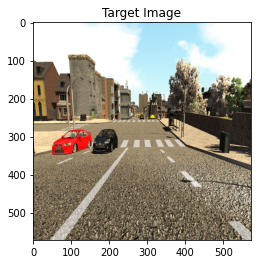

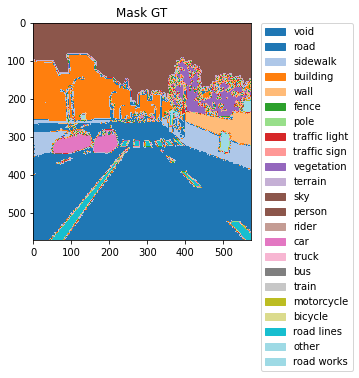

In [5]:
for i in range(1):
    _, batch = targetloader_iter.__next__()
    # Changed img = batch to img = batch[0] and defined mask
    img = batch[0]
    mask = batch[1]

    # Shows the target image
    from torchvision import transforms
    import matplotlib.pyplot as plt
    plt.figure()
    plt.title('Target Image')
    trans = transforms.ToPILImage()
    # Got rid of the one in (1, 3, 572, 572) dimensional array img[0]
    img = img[0,:,:,:]
    fig = plt.imshow(trans(img))

    # Shows the processed mask for the image
    plt.figure()
    plt.title('Mask GT')
    # Changed mask[0] to img[1]
    # Get rid of the one and four in (1, 4, 572, 572) in mask, making mask1 2D, picks the R channel
    mask1 = mask[0,0,:,:]
    values = np.unique(mask1.ravel())
    names = get_label_names()
    im = plt.imshow(mask1, cmap= 'tab20') #had tab20, nipy_spectral, gnuplot
    # get the colors of the values, according to the 
    # colormap used by imshow
    colors = [ im.cmap(im.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=names[i]) ) for i in range(len(values)) ]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )



<h1>MODEL TEST</h1>

In [32]:
def figure_draw(batch, net, device):
    img, mask= batch
    X, y = img.to(device), mask.to(device)
    pred_main = net(X)[0]
    output = pred_main.cpu().data[0].numpy()
    print("OUTPUT: ", output)
    output = output.transpose(axes=(1, 2, 0))
    pred = np.argmax(output, axis=2)

    plt.figure()
    plt.title('Image')
    trans = transforms.ToPILImage()
    plt.imshow(trans(img[0]))

    plt.figure()
    plt.title('Mask GT')
    values = np.unique(mask[0].ravel())
    im = plt.imshow(mask[0], cmap= 'tab20')
    # get the colors of the values, according to the 
    # colormap used by imshow
    colors = [ im.cmap(im.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )


In [33]:
from model import UNet
device = 'cuda:0'
net = UNet(n_channels=3, n_classes=23).to(device)

for i in range(1):
    _, batch = targetloader_iter.__next__()
    figure_draw(batch, net, device)
    


INC
torch.Size([1, 64, 572, 572])
DOWN1
torch.Size([1, 128, 286, 286])
DOWN2
torch.Size([1, 256, 143, 143])
DOWN3
torch.Size([1, 512, 71, 71])
DOWN4
torch.Size([1, 1024, 35, 35])
torch.Size([1, 1024, 35, 35])
torch.Size([1, 512, 70, 70])
SHAPE OF X1:  torch.Size([1, 512, 71, 71])
UP1
torch.Size([1, 512, 71, 71])
torch.Size([1, 512, 71, 71])
torch.Size([1, 256, 142, 142])
SHAPE OF X1:  torch.Size([1, 256, 143, 143])
UP2
torch.Size([1, 256, 143, 143])
torch.Size([1, 256, 143, 143])
torch.Size([1, 128, 286, 286])
SHAPE OF X1:  torch.Size([1, 128, 286, 286])
UP3
torch.Size([1, 128, 286, 286])
torch.Size([1, 128, 286, 286])
torch.Size([1, 64, 572, 572])
SHAPE OF X1:  torch.Size([1, 64, 572, 572])


RuntimeError: CUDA out of memory. Tried to allocate 80.00 MiB (GPU 0; 10.91 GiB total capacity; 9.80 GiB already allocated; 24.75 MiB free; 9.99 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF